In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
from matplotlib.backends.backend_agg import FigureCanvasAgg
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, KFold
from math import sqrt

plt.style.use('seaborn-darkgrid')

In [2]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [3]:
JobsDF = pd.read_csv('COVID_Jobs_Merged.csv', index_col = 0)
JobsDF.head()

,State,cases,deaths,All Occupations 2018,Computer Mathematical Scientists 2018,Computer Mathematical Scientists 2018 (Percent),Engineers 2018,Engineers 2018 (Percent),Life Scientists 2018,Life Scientists 2018 (Percent),Physical Scientists 2018,Physical Scientists 2018 (Percent),Science Engineer Workers 2018,Science Engineer Workers 2018 (Percent),Social Scientists 2018,Social Scientists 2018 (Percent),Technical Workers 2018,Technical Workers 2018 (Percent)
0,Alabama,387786,14345,1943760.0,34810.0,1.790859,32340.0,1.663786,3180.0,0.163600,2780.0,NaN,69821.428571,3.727577,3195.000000,0.170005,25768.461538,1.377782
1,Alaska,18316,367,315250.0,4820.0,1.528945,5060.0,1.605075,1830.0,0.580492,1670.0,NaN,14480.000000,4.593180,1090.000000,0.345757,6370.000000,2.020619
2,Arizona,426614,18857,2789520.0,92170.0,3.304153,35180.0,1.261149,4480.0,0.160601,4174.0,NaN,114216.428571,4.532470,7870.000000,0.282127,40286.923077,1.608712
3,Arkansas,161569,3301,1210120.0,21960.0,1.814696,8190.0,0.676792,2210.0,0.182627,1462.0,NaN,35500.000000,2.933593,2426.923077,0.209530,11790.000000,0.974284
4,California,2664110,102387,17007690.0,592510.0,3.483777,243550.0,1.431999,63800.0,0.375124,39360.0,NaN,989560.000000,5.818309,50350.000000,0.296043,266500.000000,1.566938


In [4]:
JobsDF.drop([col for col in JobsDF.columns if '(Percent)' in col], axis = 1, inplace = True)
JobsDF = JobsDF.drop(columns = ['cases', 'deaths'])
JobsDF.head()

,State,All Occupations 2018,Computer Mathematical Scientists 2018,Engineers 2018,Life Scientists 2018,Physical Scientists 2018,Science Engineer Workers 2018,Social Scientists 2018,Technical Workers 2018
0,Alabama,1943760.0,34810.0,32340.0,3180.0,2780.0,69821.428571,3195.000000,25768.461538
1,Alaska,315250.0,4820.0,5060.0,1830.0,1670.0,14480.000000,1090.000000,6370.000000
2,Arizona,2789520.0,92170.0,35180.0,4480.0,4174.0,114216.428571,7870.000000,40286.923077
3,Arkansas,1210120.0,21960.0,8190.0,2210.0,1462.0,35500.000000,2426.923077,11790.000000
4,California,17007690.0,592510.0,243550.0,63800.0,39360.0,989560.000000,50350.000000,266500.000000


In [5]:
JobsDF = JobsDF.round({'Science Engineer Workers 2018':1,
                      'Social Scientists 2018':1,
                      'Technical Workers 2018':1})
JobsDF.head()

,State,All Occupations 2018,Computer Mathematical Scientists 2018,Engineers 2018,Life Scientists 2018,Physical Scientists 2018,Science Engineer Workers 2018,Social Scientists 2018,Technical Workers 2018
0,Alabama,1943760.0,34810.0,32340.0,3180.0,2780.0,69821.4,3195.0,25768.5
1,Alaska,315250.0,4820.0,5060.0,1830.0,1670.0,14480.0,1090.0,6370.0
2,Arizona,2789520.0,92170.0,35180.0,4480.0,4174.0,114216.4,7870.0,40286.9
3,Arkansas,1210120.0,21960.0,8190.0,2210.0,1462.0,35500.0,2426.9,11790.0
4,California,17007690.0,592510.0,243550.0,63800.0,39360.0,989560.0,50350.0,266500.0


In [6]:
COVID_Case = pd.read_csv('COVID.csv', index_col = 0)
COVID_Case.head()

,State,cases,deaths
0,Alabama,26912,785
1,Alaska,751,10
2,Arizona,39298,1228
3,Arkansas,13191,188
4,California,159098,5202


In [7]:
JobsDF = pd.merge(JobsDF, COVID_Case, how = 'left', on = 'State')
JobsDF.head()

,State,All Occupations 2018,Computer Mathematical Scientists 2018,Engineers 2018,Life Scientists 2018,Physical Scientists 2018,Science Engineer Workers 2018,Social Scientists 2018,Technical Workers 2018,cases,deaths
0,Alabama,1943760.0,34810.0,32340.0,3180.0,2780.0,69821.4,3195.0,25768.5,26912,785
1,Alaska,315250.0,4820.0,5060.0,1830.0,1670.0,14480.0,1090.0,6370.0,751,10
2,Arizona,2789520.0,92170.0,35180.0,4480.0,4174.0,114216.4,7870.0,40286.9,39298,1228
3,Arkansas,1210120.0,21960.0,8190.0,2210.0,1462.0,35500.0,2426.9,11790.0,13191,188
4,California,17007690.0,592510.0,243550.0,63800.0,39360.0,989560.0,50350.0,266500.0,159098,5202


In [8]:
df=JobsDF
test_len = int(0.25 * len(df))
train_len = len(df) - test_len
print('Train Set Len: ' + str(train_len))
print('Test Set Len: ' + str(test_len))

train = df[:train_len]
test = df[train_len:]
print('Train Set Shape: ' + str(train.shape))
print('Test Set Shape: ' + str(test.shape))

Train Set Len: 39
Test Set Len: 12
Train Set Shape: (39, 11)
Test Set Shape: (12, 11)


In [9]:
features_list = ['Computer Mathematical Scientists 2018']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

RandomForestModel = RandomForestRegressor()
RandomForestModel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = RandomForestModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = RandomForestModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 11348.65186324787
Train MSE Value: 543451052.5263656
Train RMS Value: 23312.036644754266
Train R2 Score: 0.8877125659038873


Test MAE Value: 24227.571361111117
Test MSE Value: 2821158964.5529847
Test RMS Value: 53114.58335102502
Test R2 Score: -3.11349437427772


C:\Users\Nithin Reddy Malyala\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


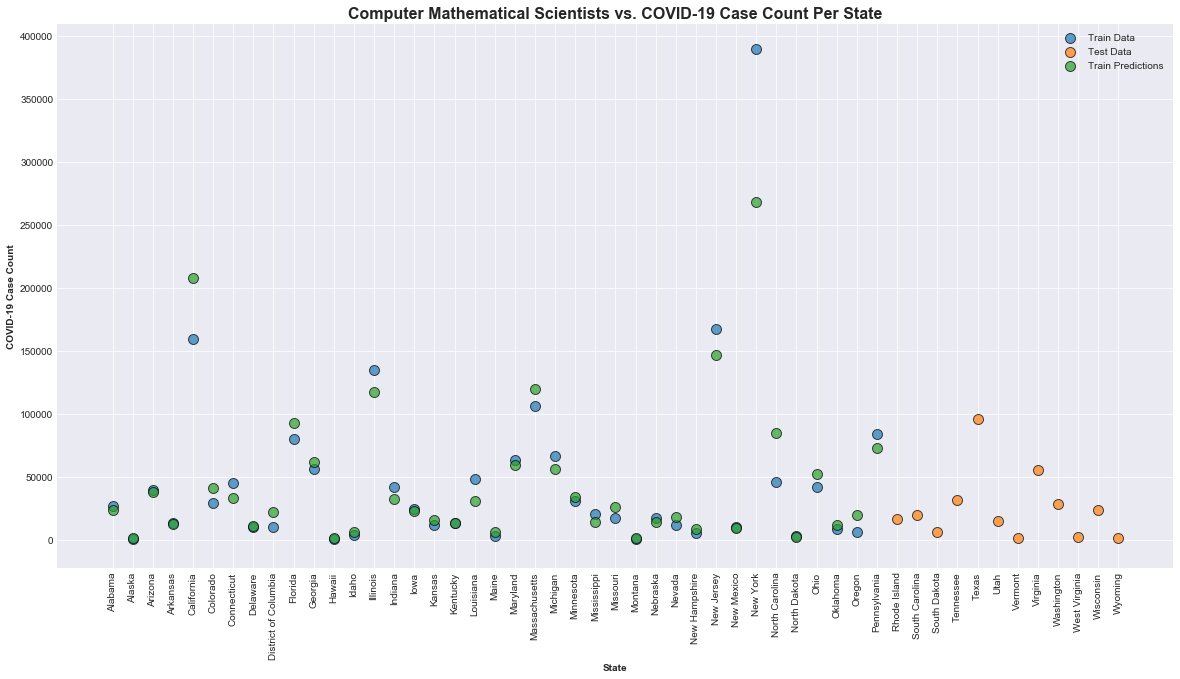

In [10]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Computer Mathematical Scientists vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();


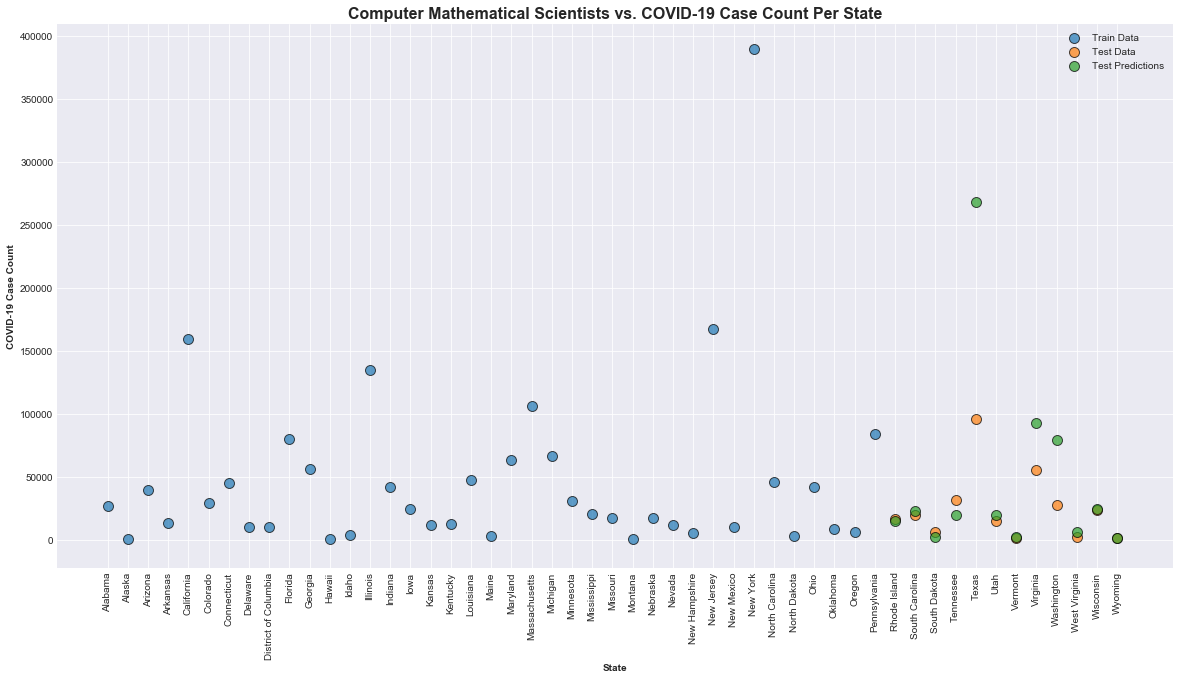

In [11]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Computer Mathematical Scientists vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [12]:
evaluate(RandomForestModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7983 degrees.
Accuracy = 91.17%.


91.17431944293624

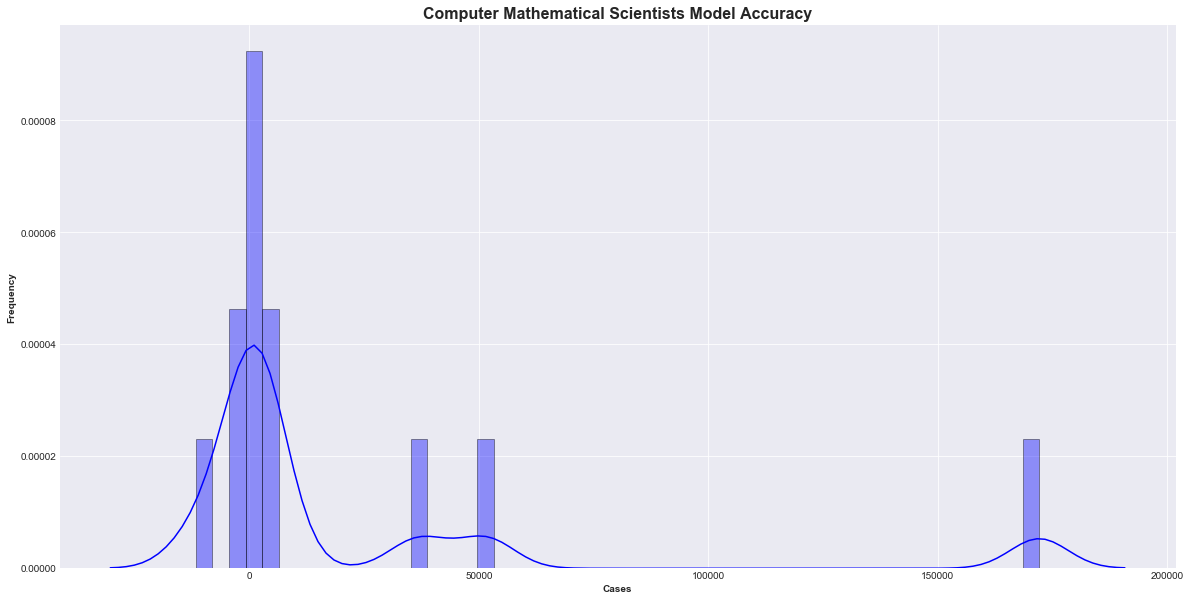

In [13]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Computer Mathematical Scientists Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [14]:
features_list = ['Engineers 2018']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

RandomForestModel = RandomForestRegressor()
RandomForestModel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = RandomForestModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = RandomForestModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 13495.41247863247
Train MSE Value: 865317837.8252214
Train RMS Value: 29416.285248569737
Train R2 Score: 0.8212087008842872


Test MAE Value: 16299.84291666666
Test MSE Value: 690745467.2015933
Test RMS Value: 26282.03696827157
Test R2 Score: -0.007166781132380562


C:\Users\Nithin Reddy Malyala\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


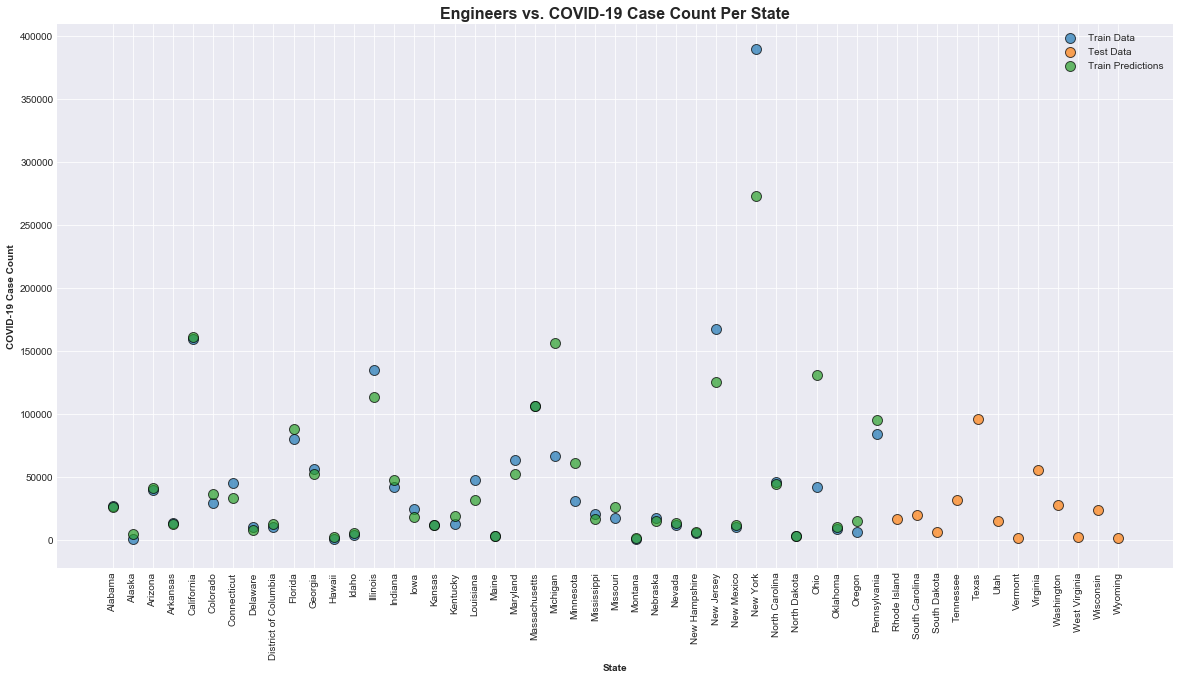

In [15]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Engineers vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();


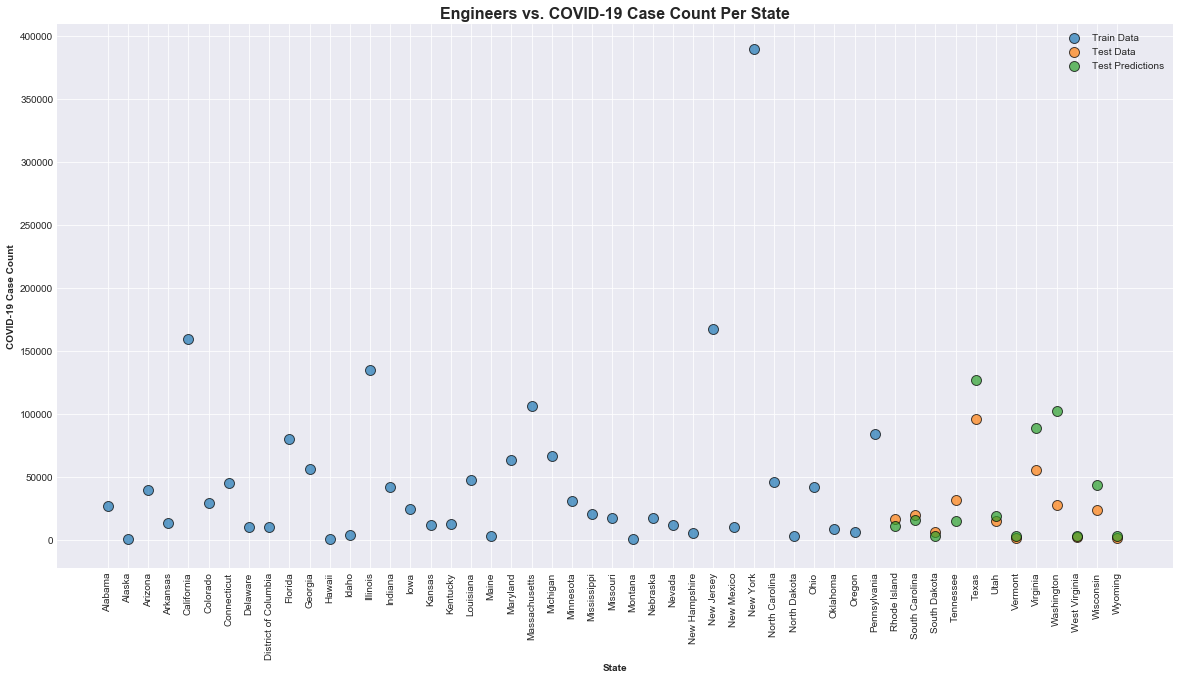

In [16]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Engineers vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [17]:
evaluate(RandomForestModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8193 degrees.
Accuracy = 94.84%.


94.83751862250604

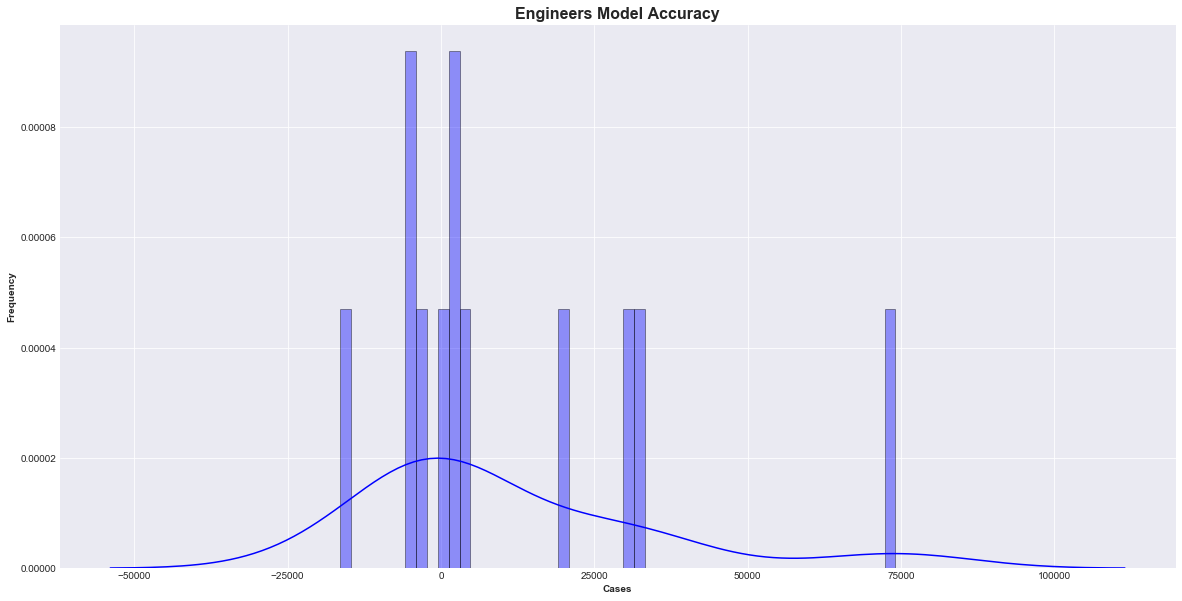

In [18]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Engineers Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [19]:
features_list = ['Life Scientists 2018']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

RandomForestModel = RandomForestRegressor()
RandomForestModel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = RandomForestModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = RandomForestModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 11114.029628205128
Train MSE Value: 434708415.2228498
Train RMS Value: 20849.662232824056
Train R2 Score: 0.9101808851074159


Test MAE Value: 33066.03391666664
Test MSE Value: 4511240446.873085
Test RMS Value: 67165.76841571221
Test R2 Score: -5.577779711242507


C:\Users\Nithin Reddy Malyala\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


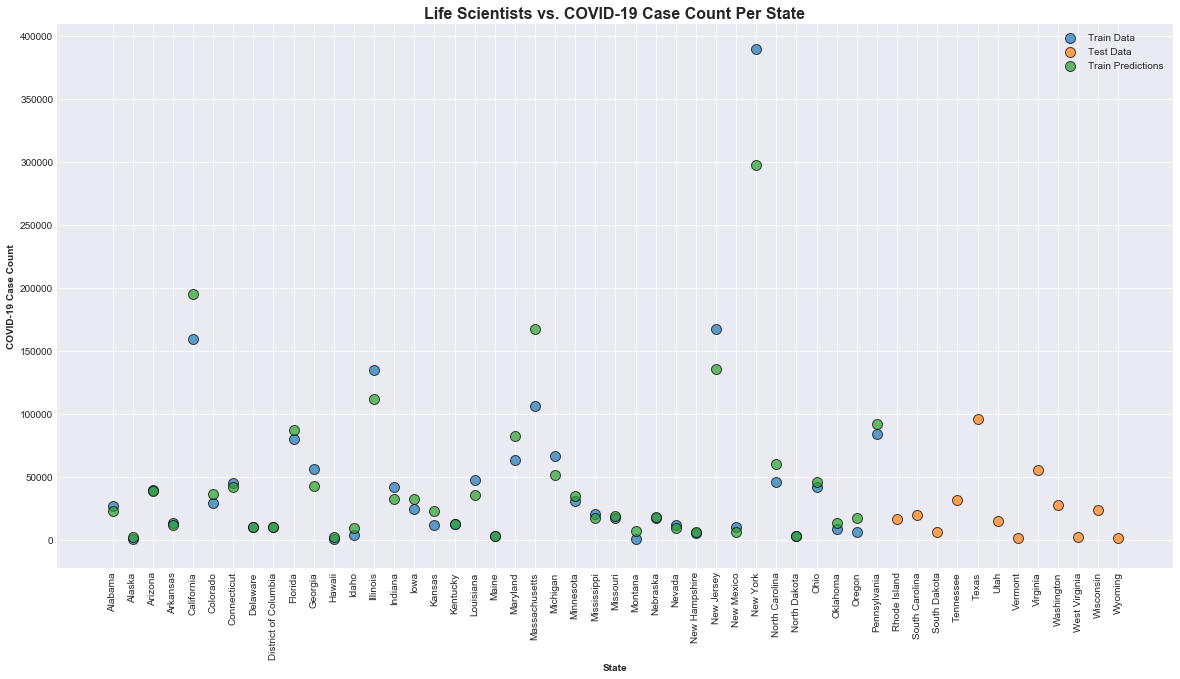

In [20]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Life Scientists vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();


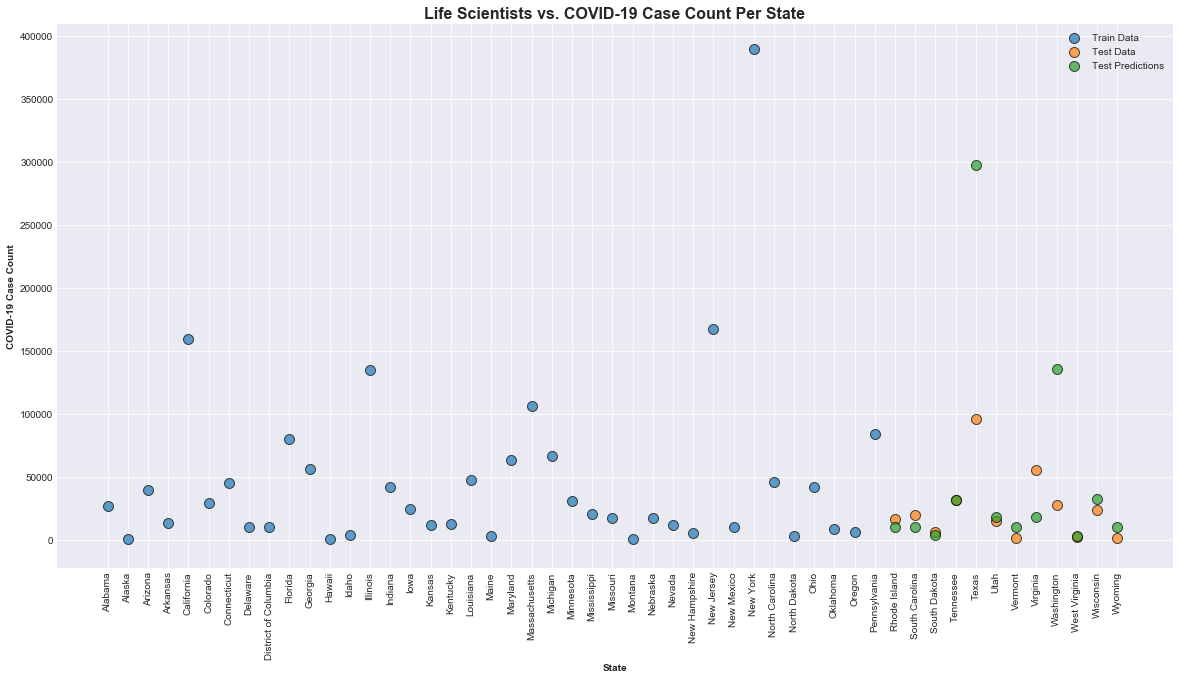

In [21]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Life Scientists vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [22]:
evaluate(RandomForestModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8129 degrees.
Accuracy = 89.99%.


89.98794703912672

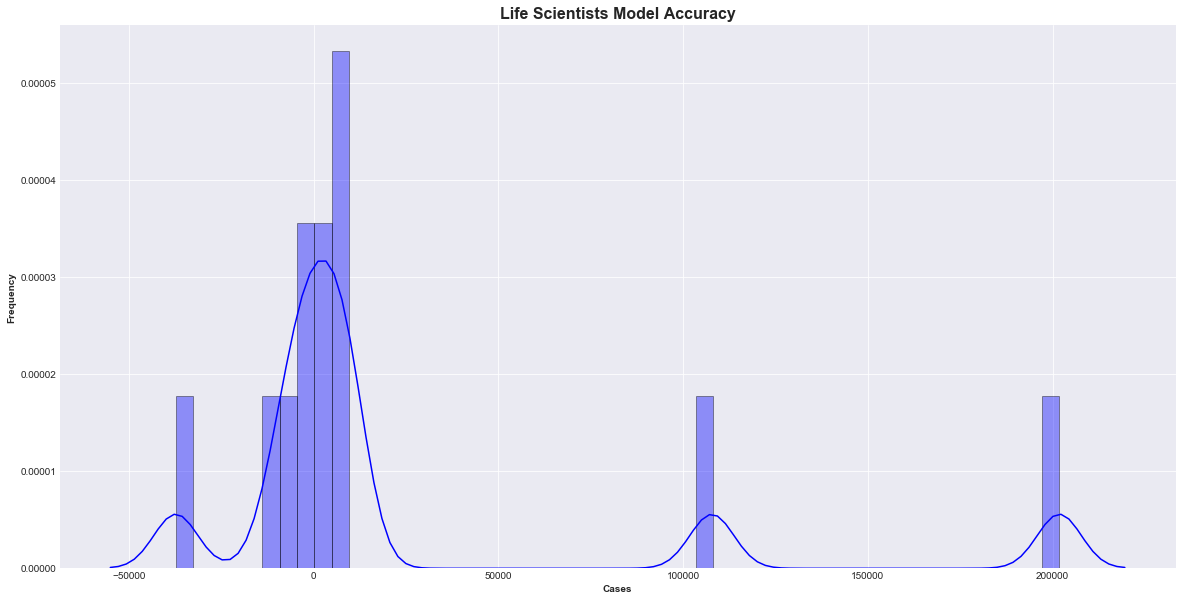

In [23]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Life Scientists Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [24]:
features_list = ['Physical Scientists 2018']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

RandomForestModel = RandomForestRegressor()
RandomForestModel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = RandomForestModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = RandomForestModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 11230.111837606839
Train MSE Value: 434154501.90310025
Train RMS Value: 20836.374490373804
Train R2 Score: 0.9102953342470343


Test MAE Value: 26890.600305555552
Test MSE Value: 3445467330.638279
Test RMS Value: 58698.10329676998
Test R2 Score: -4.0237901016626845


C:\Users\Nithin Reddy Malyala\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


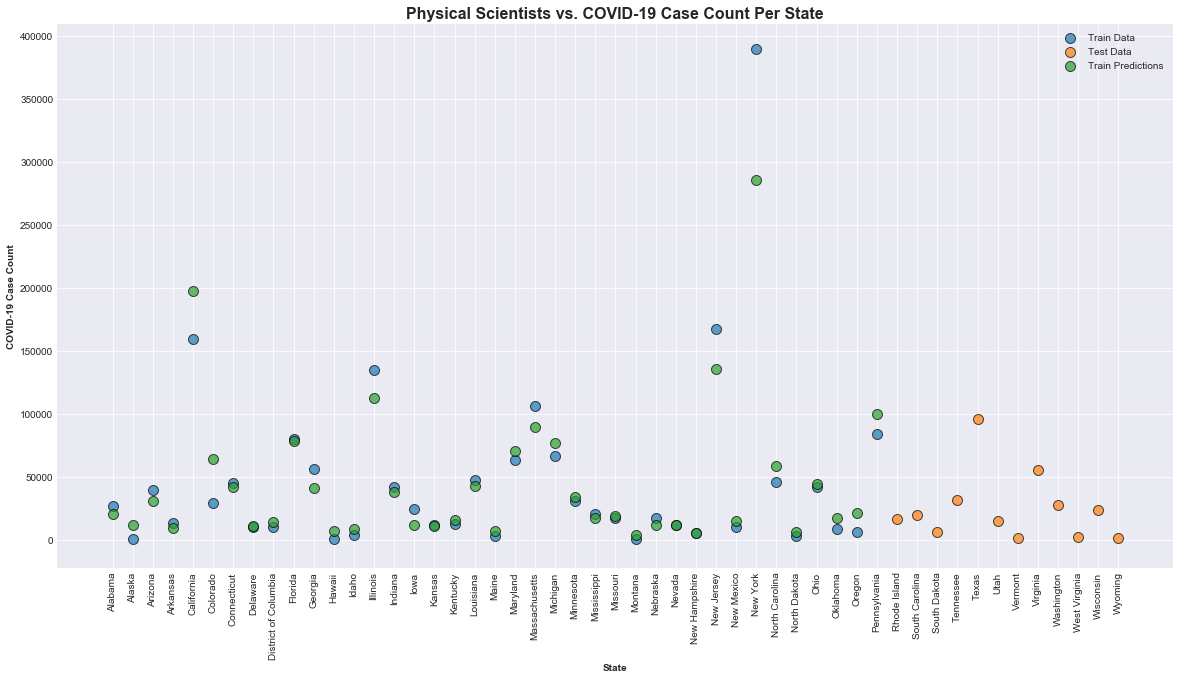

In [25]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Physical Scientists vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();


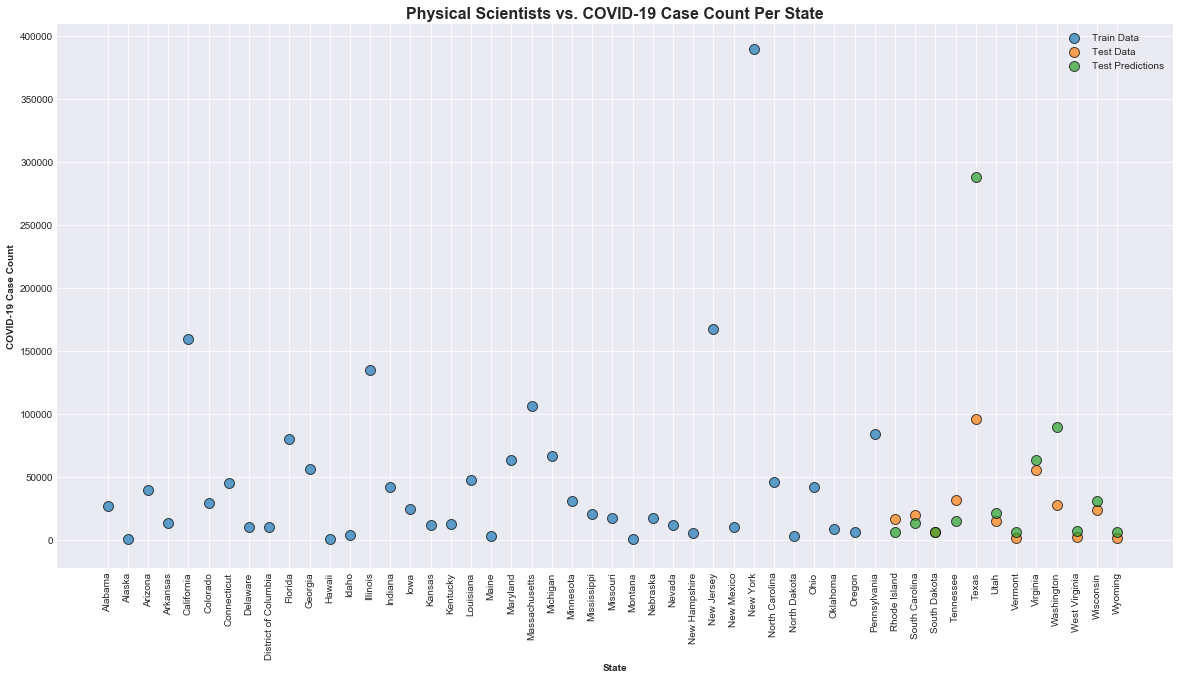

In [26]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Physical Scientists vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [27]:
evaluate(RandomForestModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7879 degrees.
Accuracy = 90.80%.


90.79671372264472

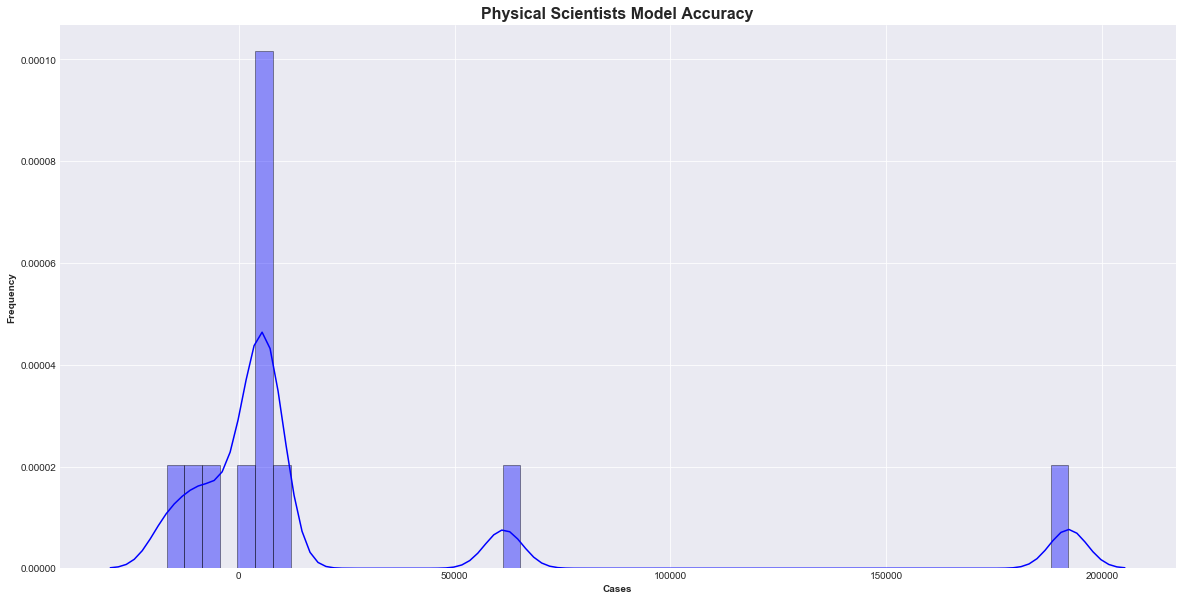

In [28]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Physical Scientists Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [29]:
features_list = ['Science Engineer Workers 2018']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

RandomForestModel = RandomForestRegressor()
RandomForestModel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = RandomForestModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = RandomForestModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 11414.658179487193
Train MSE Value: 430638187.0699093
Train RMS Value: 20751.823704674953
Train R2 Score: 0.9110218724849448


Test MAE Value: 28218.982041666663
Test MSE Value: 3695273180.494941
Test RMS Value: 60788.75866881097
Test R2 Score: -4.3880286897600635


C:\Users\Nithin Reddy Malyala\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


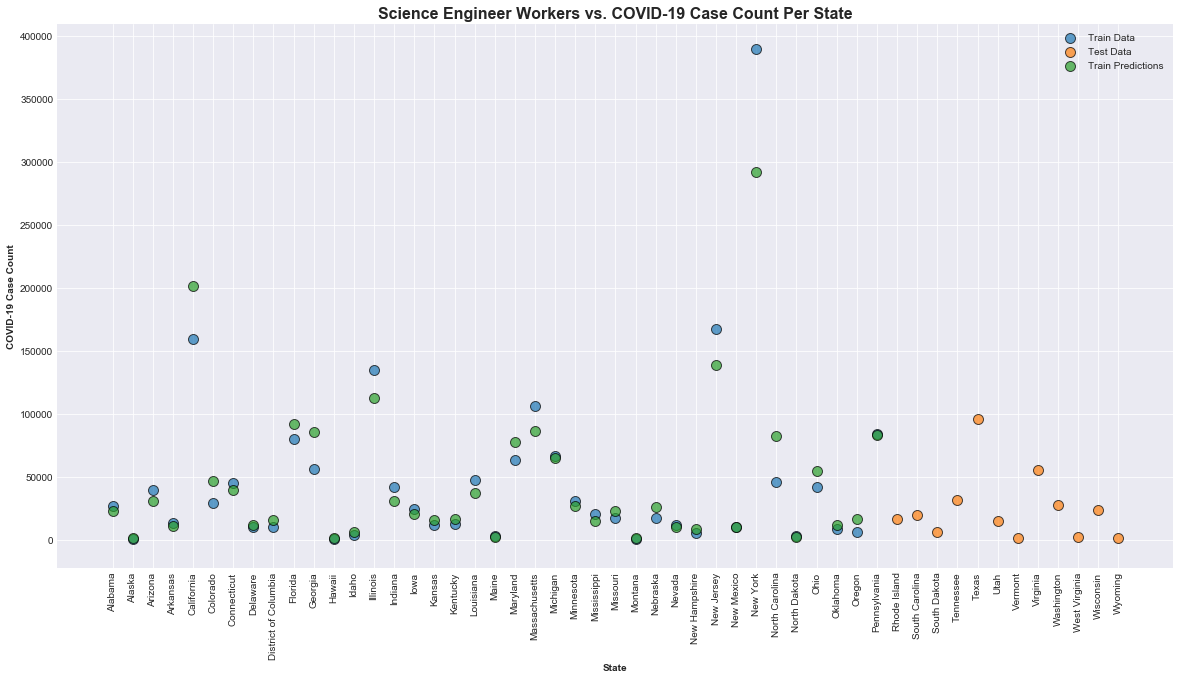

In [30]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Science Engineer Workers vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();


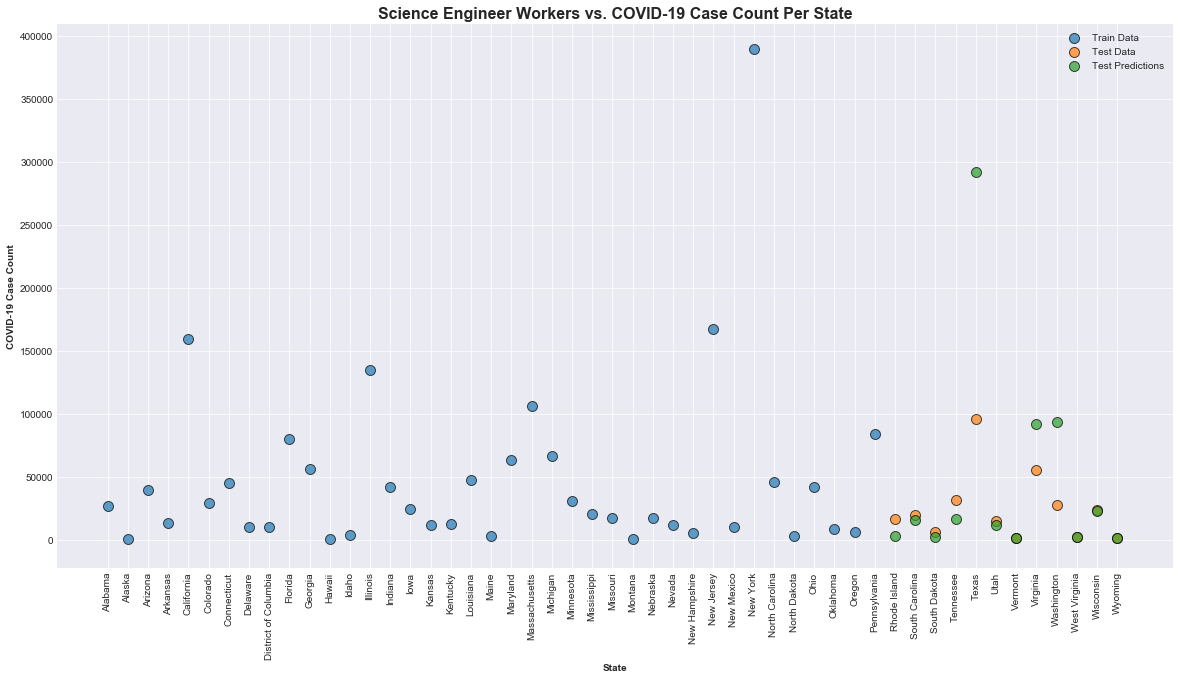

In [31]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Science Engineer Workers vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [32]:
evaluate(RandomForestModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8066 degrees.
Accuracy = 92.77%.


92.77101799959293

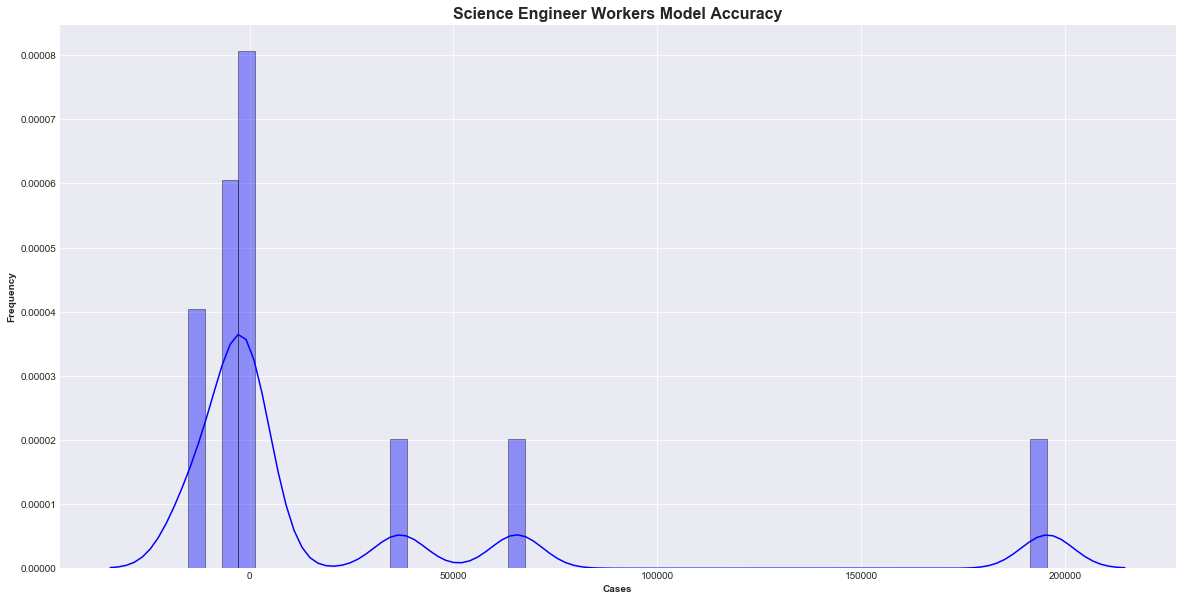

In [33]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Science Engineer Workers Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [34]:
features_list = ['Social Scientists 2018']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

RandomForestModel = RandomForestRegressor()
RandomForestModel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = RandomForestModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = RandomForestModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 11202.998974358974
Train MSE Value: 408907330.6354772
Train RMS Value: 20221.457183780727
Train R2 Score: 0.9155118851519366


Test MAE Value: 11849.249166666668
Test MSE Value: 337244031.221259
Test RMS Value: 18364.20516170681
Test R2 Score: 0.5082689622889791


C:\Users\Nithin Reddy Malyala\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


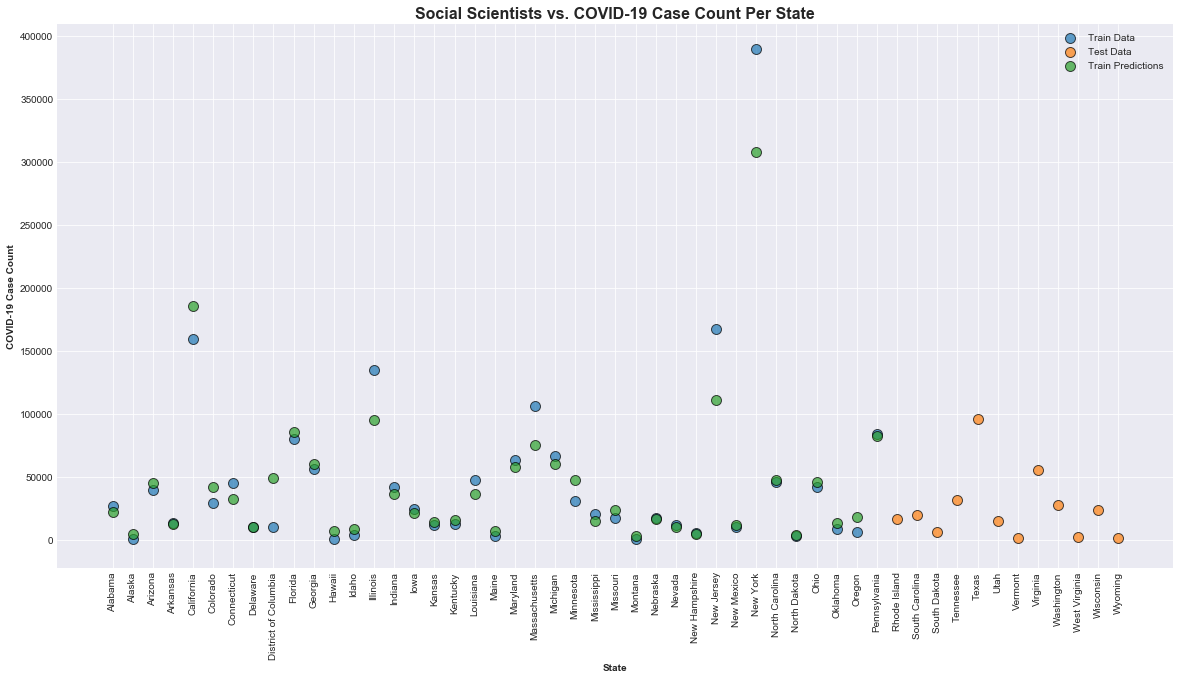

In [35]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Social Scientists vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();


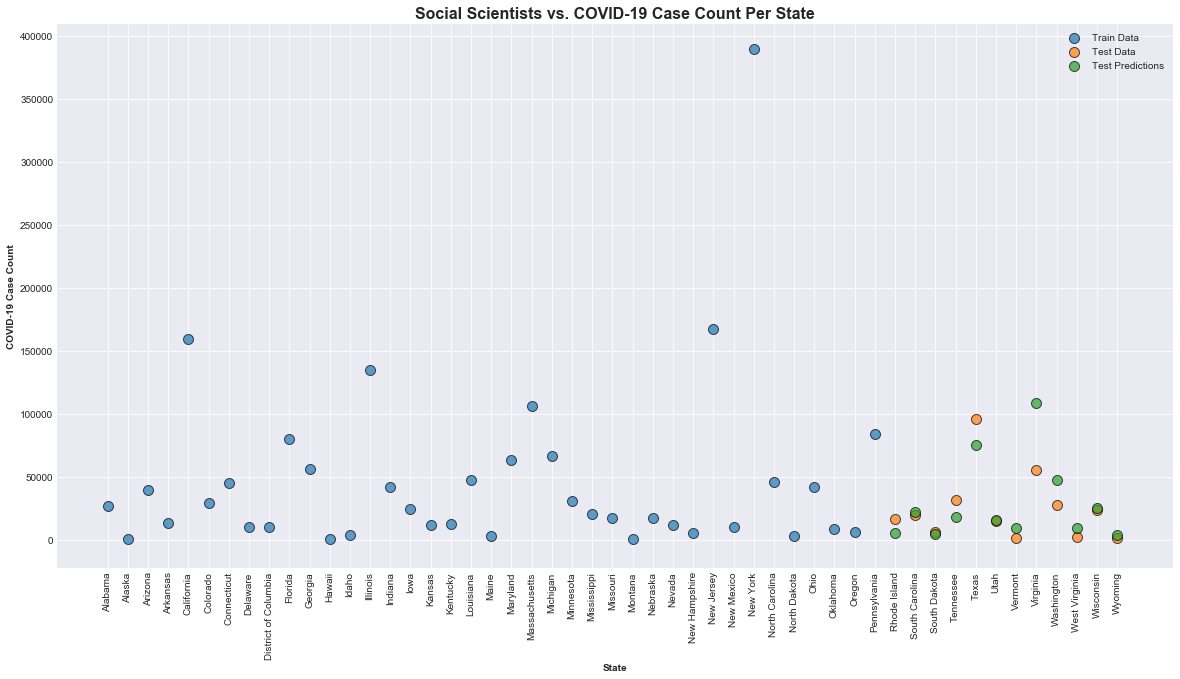

In [36]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Social Scientists vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [37]:
evaluate(RandomForestModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7681 degrees.
Accuracy = 93.51%.


93.50851194951663

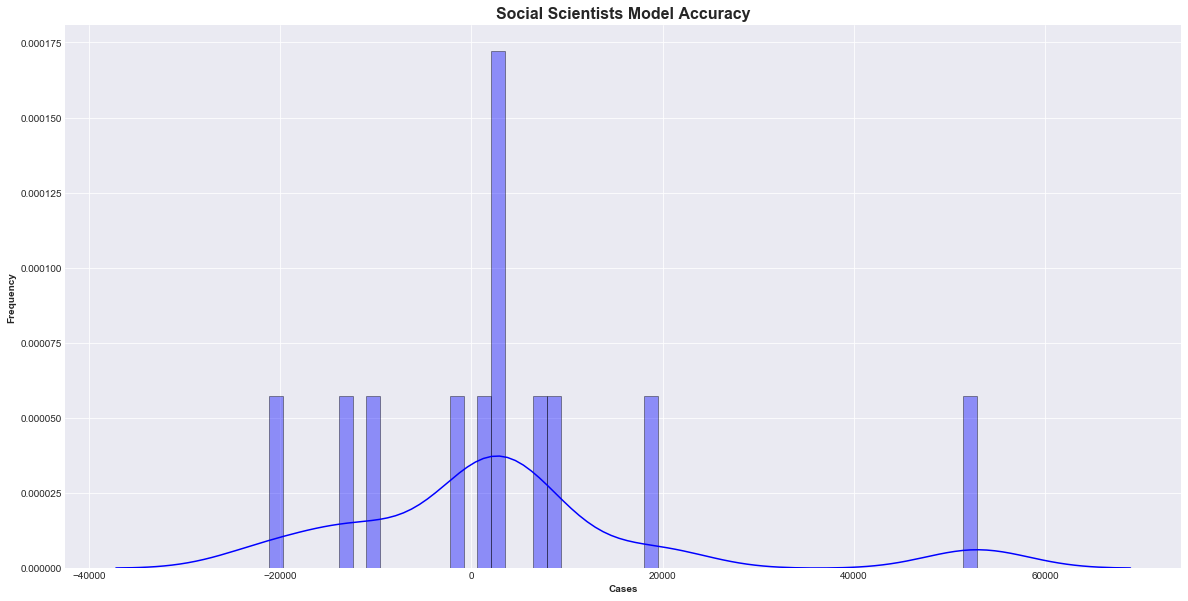

In [38]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Social Scientists Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [39]:
features_list = ['Technical Workers 2018']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

RandomForestModel = RandomForestRegressor()
RandomForestModel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = RandomForestModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = RandomForestModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 11681.902201465202
Train MSE Value: 613493517.8234439
Train RMS Value: 24768.801299688363
Train R2 Score: 0.873240446162076


Test MAE Value: 21140.434513888893
Test MSE Value: 2433046196.701706
Test RMS Value: 49325.91810297813
Test R2 Score: -2.5475923080697784


C:\Users\Nithin Reddy Malyala\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


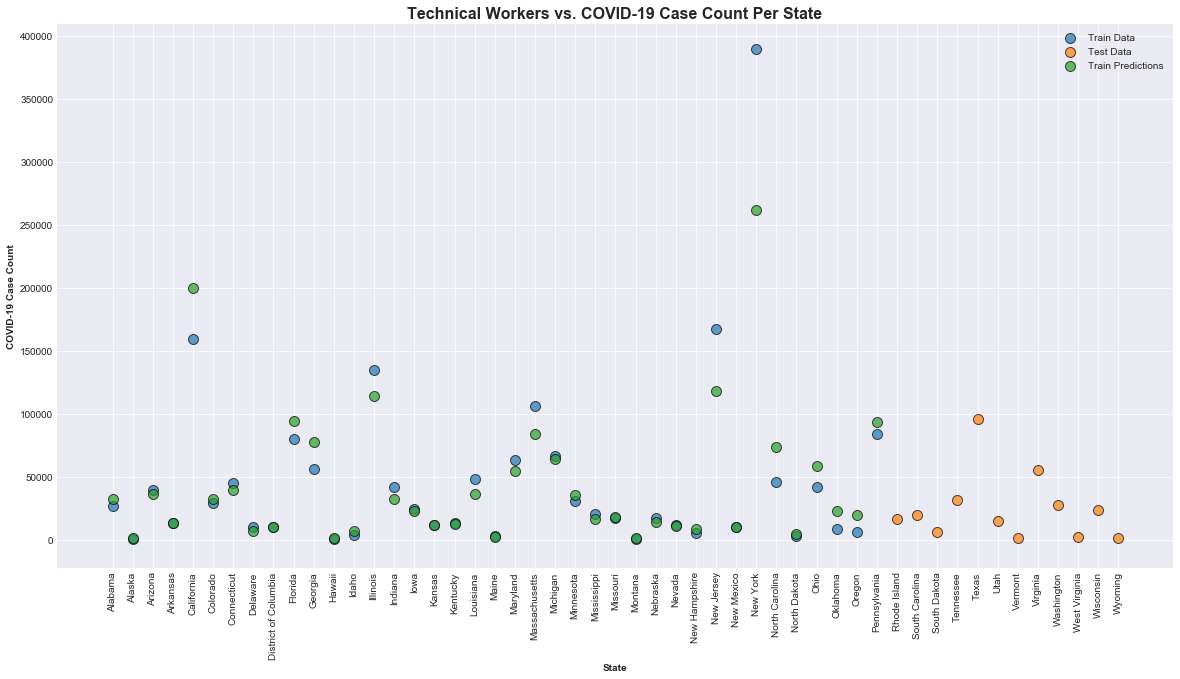

In [40]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Technical Workers vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();


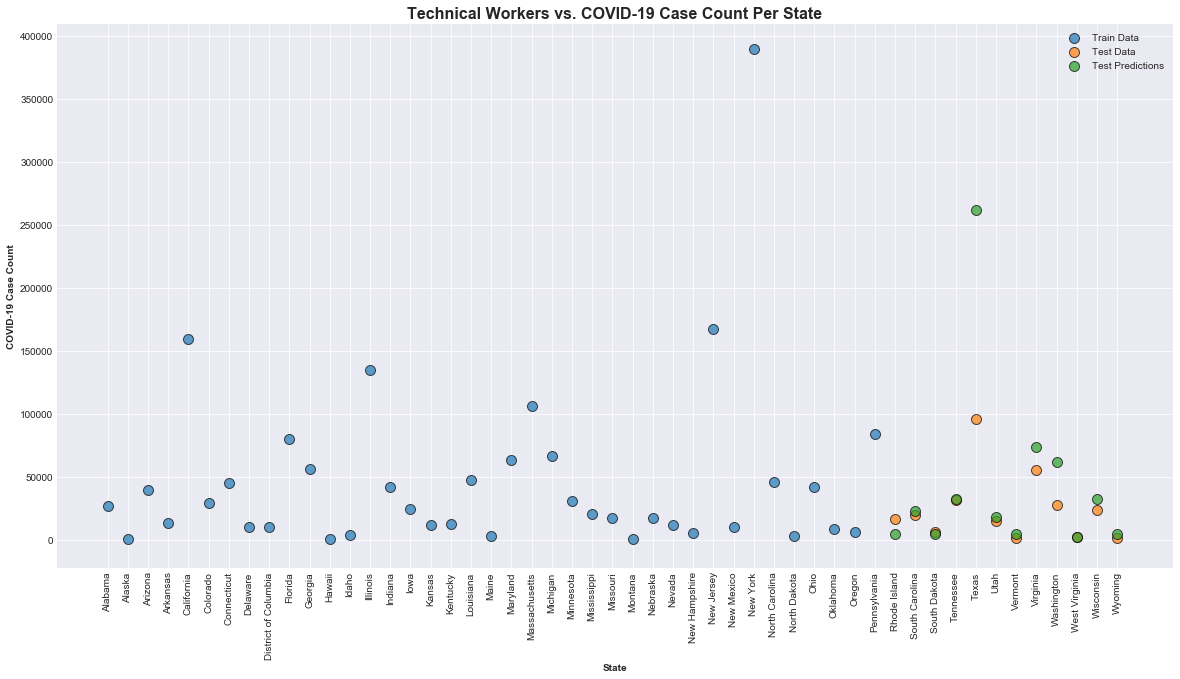

In [41]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Technical Workers vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [42]:
evaluate(RandomForestModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7842 degrees.
Accuracy = 90.93%.


90.93358137883732

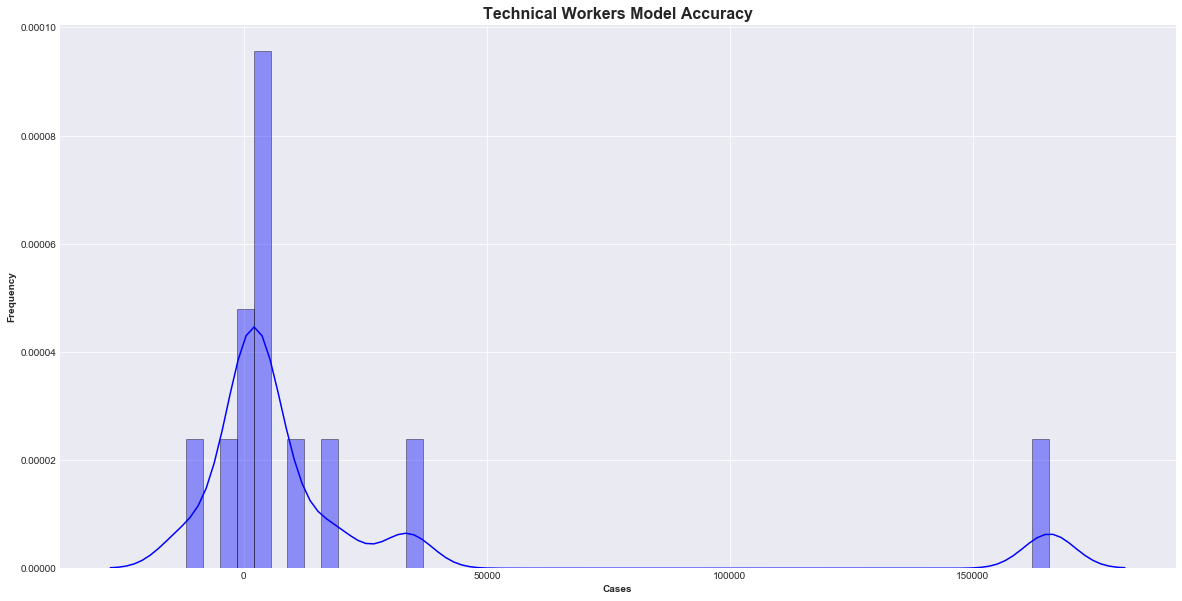

In [43]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Technical Workers Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [44]:
features_list = ['All Occupations 2018']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

RandomForestModel = RandomForestRegressor()
RandomForestModel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = RandomForestModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = RandomForestModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 11281.784897435908
Train MSE Value: 608120612.8798281
Train RMS Value: 24660.10163968973
Train R2 Score: 0.8743505916056376


Test MAE Value: 27216.78166666666
Test MSE Value: 3263076467.3733563
Test RMS Value: 57123.34432938391
Test R2 Score: -3.757848409121869


C:\Users\Nithin Reddy Malyala\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


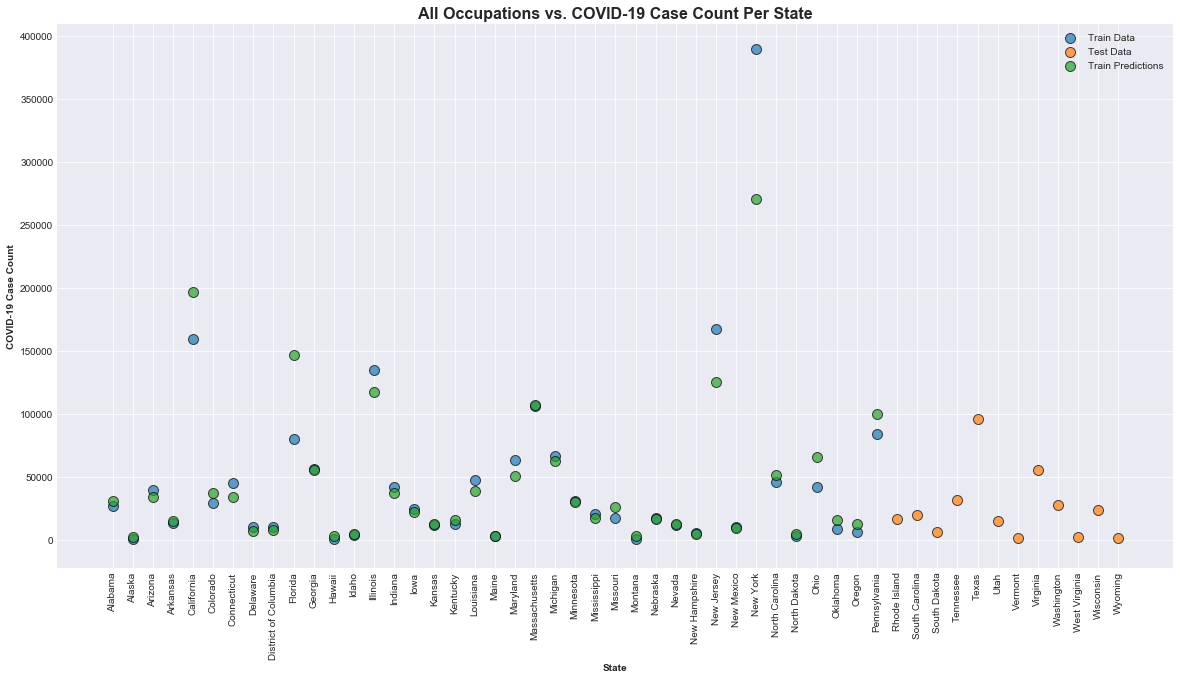

In [45]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('All Occupations vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();


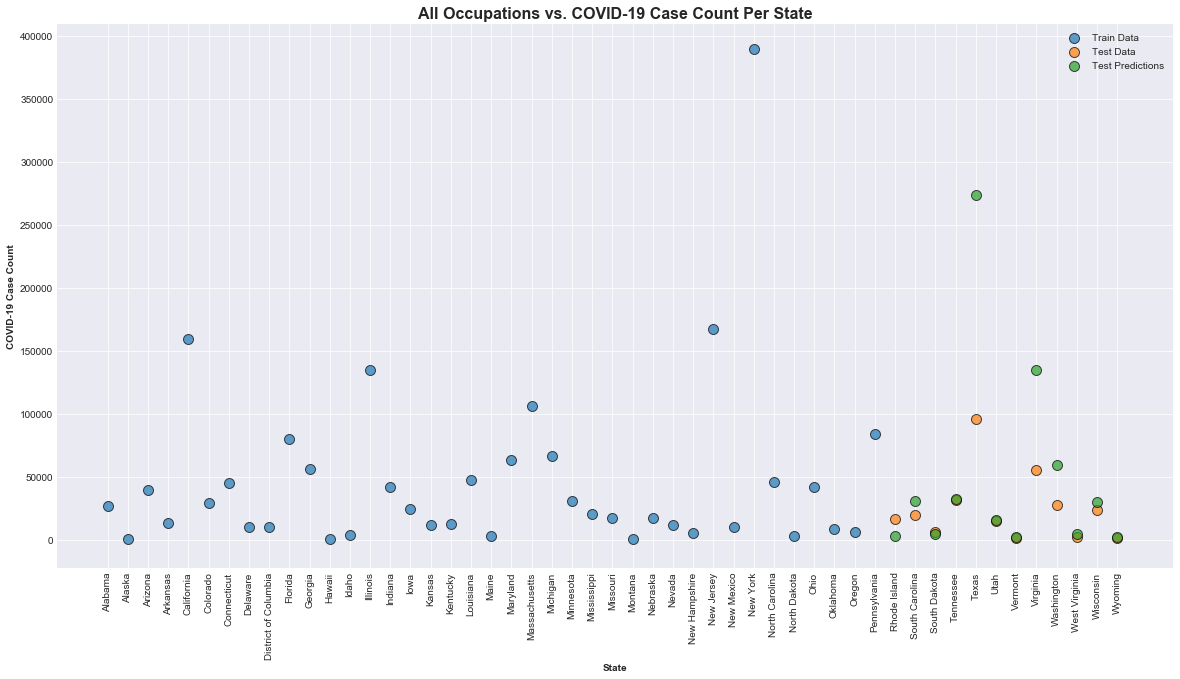

In [46]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('All Occupations vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [47]:
evaluate(RandomForestModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8040 degrees.
Accuracy = 90.85%.


90.84814074290774

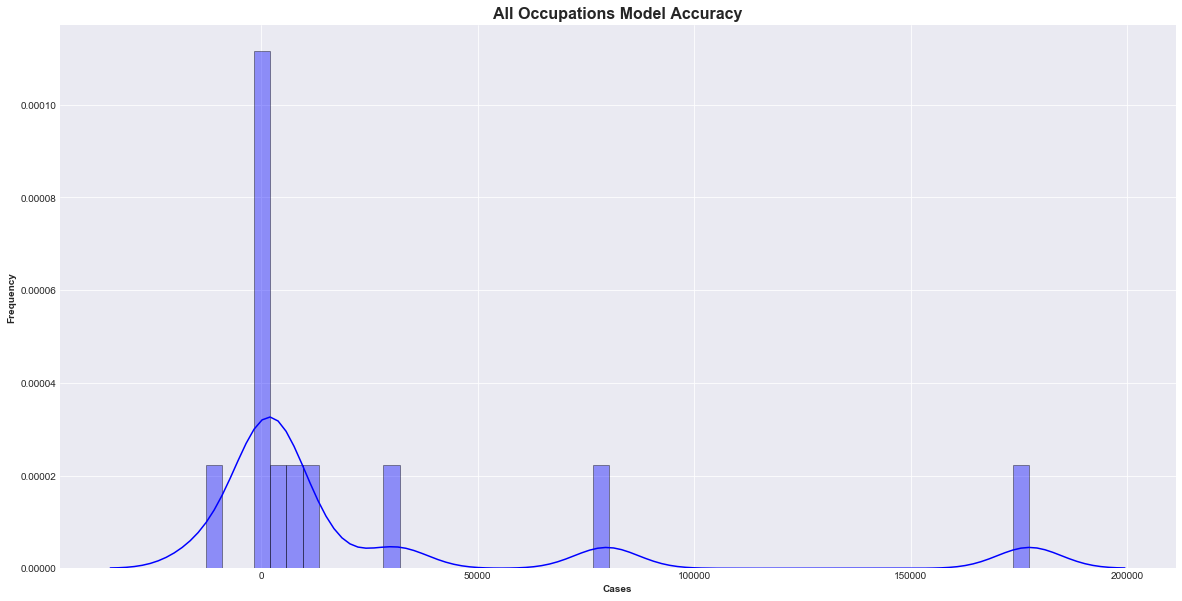

In [48]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('All Occupations Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [49]:
features_list = ['Computer Mathematical Scientists 2018', 'Engineers 2018', 'Life Scientists 2018',
                 'Physical Scientists 2018', 'Science Engineer Workers 2018', 'Social Scientists 2018', 
                 'Technical Workers 2018']
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

RandomForestModel = RandomForestRegressor()
RandomForestModel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = RandomForestModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = RandomForestModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 9849.191149572654
Train MSE Value: 354122178.69684035
Train RMS Value: 18818.1343043576
Train R2 Score: 0.9268315506657995


Test MAE Value: 24165.729111111115
Test MSE Value: 2788613412.242107
Test RMS Value: 52807.3234716749
Test R2 Score: -3.0660401371997423


C:\Users\Nithin Reddy Malyala\anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


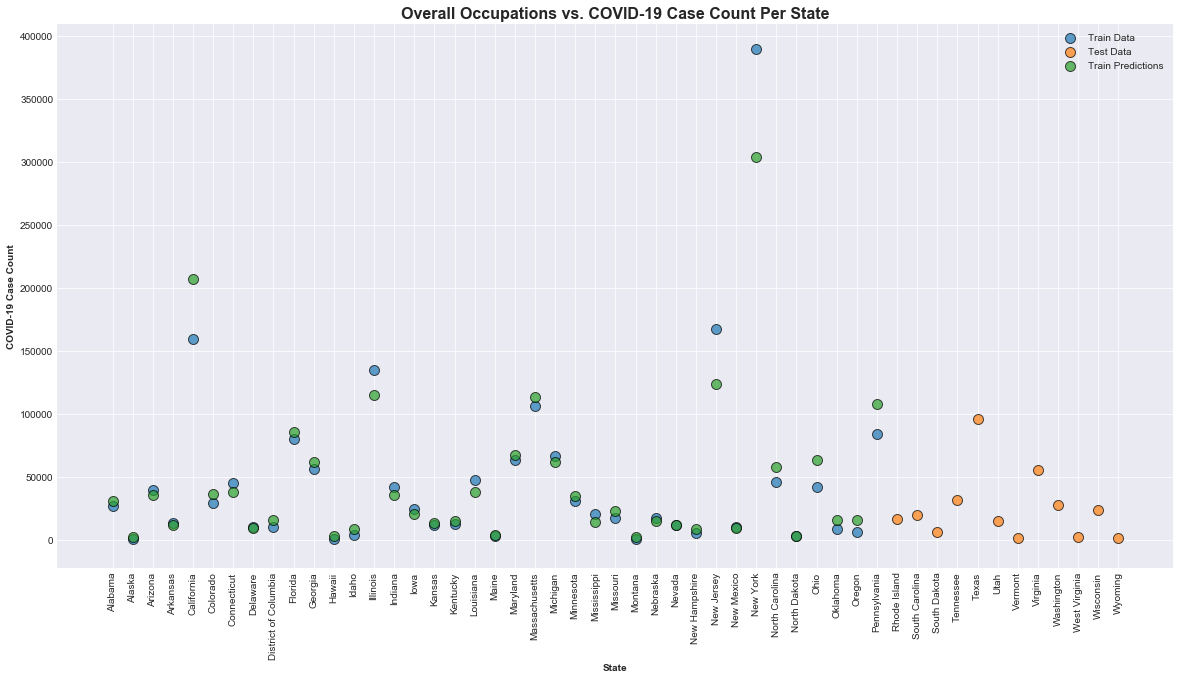

In [50]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall Occupations vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

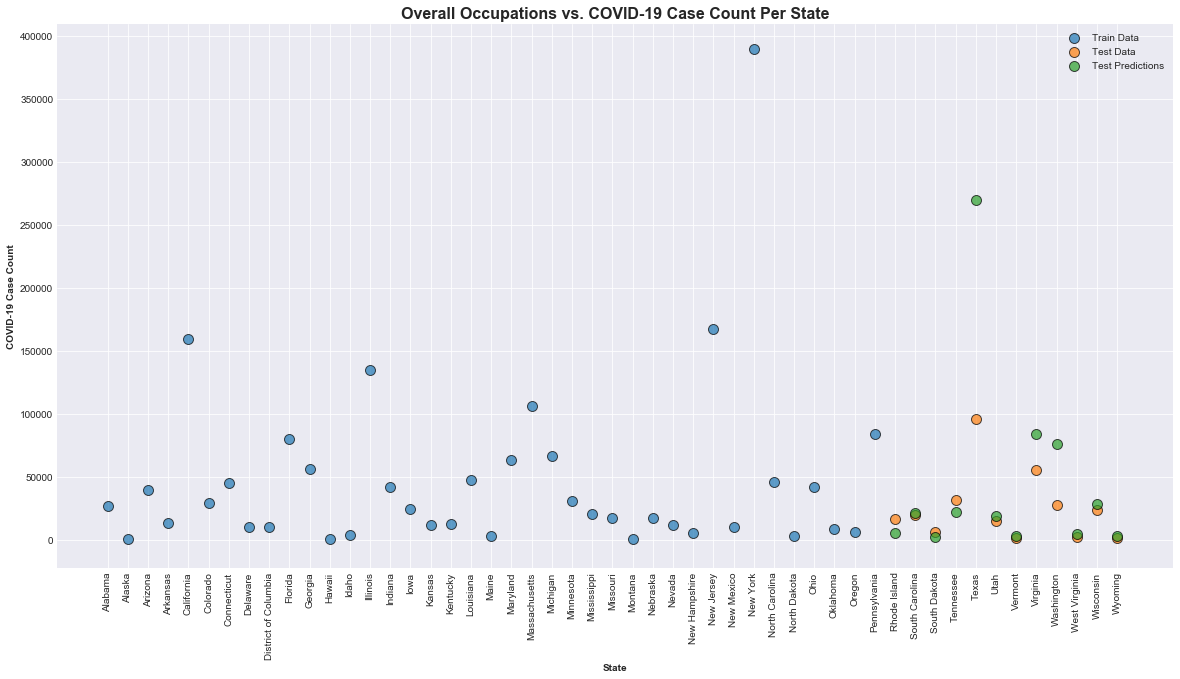

In [51]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall Occupations vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [52]:
evaluate(RandomForestModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8074 degrees.
Accuracy = 92.11%.


92.11075481634643

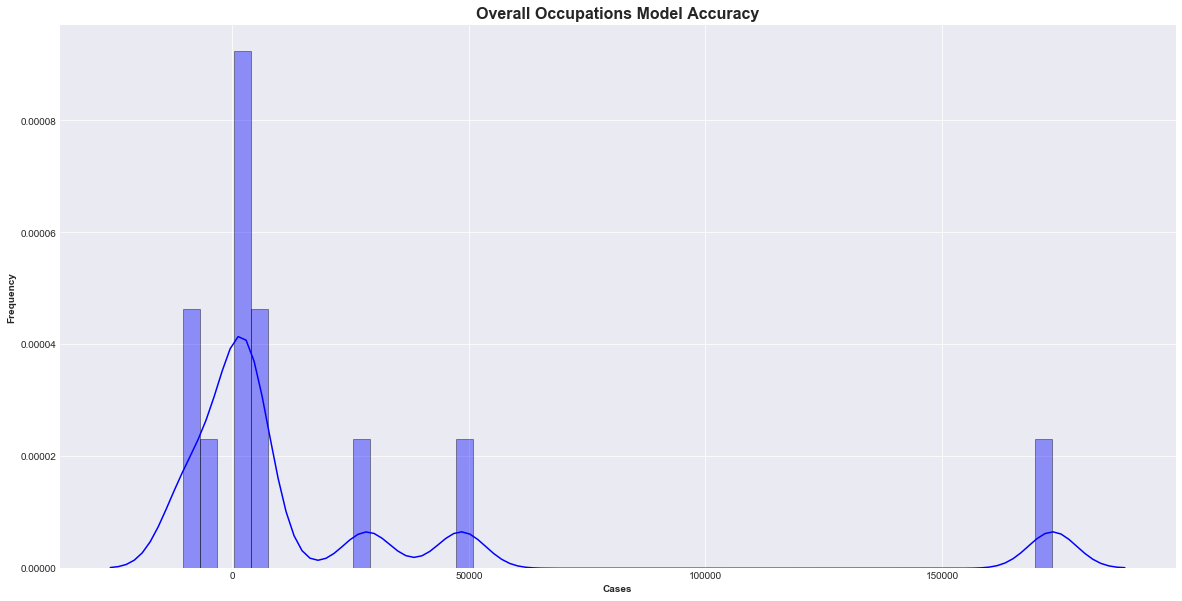

In [53]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Overall Occupations Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [54]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [7],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 400, 500, 1000]
}

kfold = KFold(n_splits = 4)

RF_NewModel = GridSearchCV(estimator = RandomForestModel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

RF_NewModel.fit(X_train_scaled, y_train_scaled);

Fitting 4 folds for each of 216 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  3.4min finished
C:\Users\Nithin Reddy Malyala\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [55]:
RF_NewModel.best_params_

train_predictions_scaled = RF_NewModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = RF_NewModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 15484.247360655321
Train MSE Value: 1396644296.080574
Train RMS Value: 37371.70448455053
Train R2 Score: 0.7114264410330664


Test MAE Value: 17155.280704500685
Test MSE Value: 897121343.4380766
Test RMS Value: 29951.983964974283
Test R2 Score: -0.3080807021669303


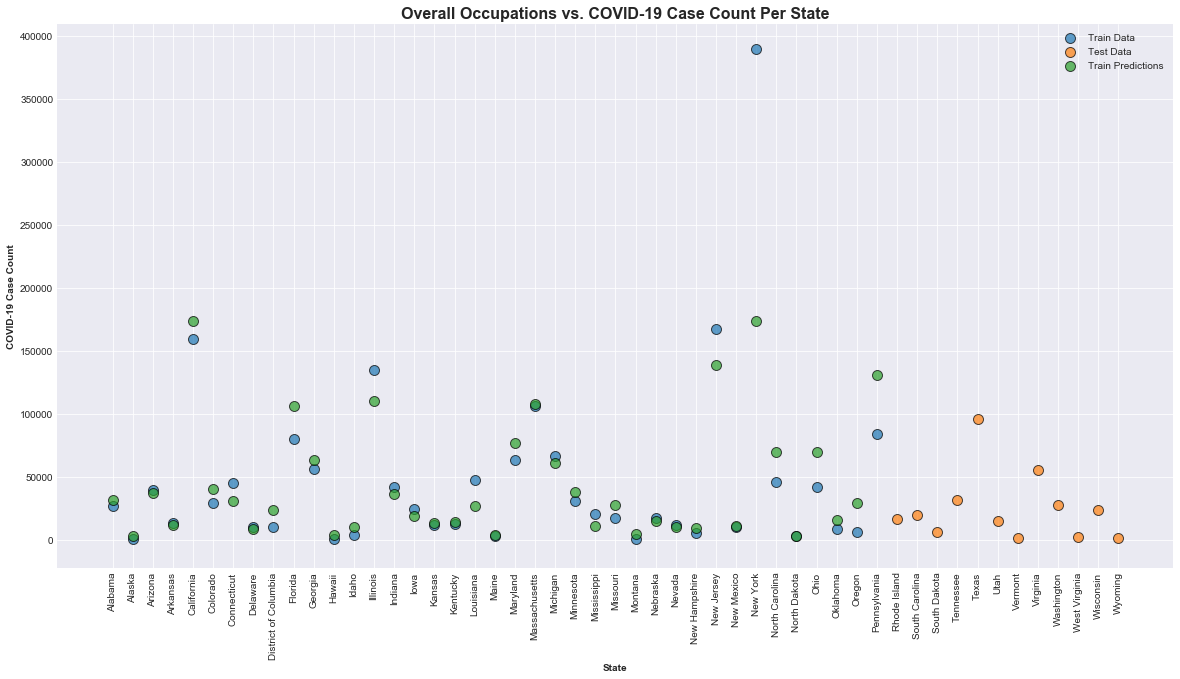

In [56]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall Occupations vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

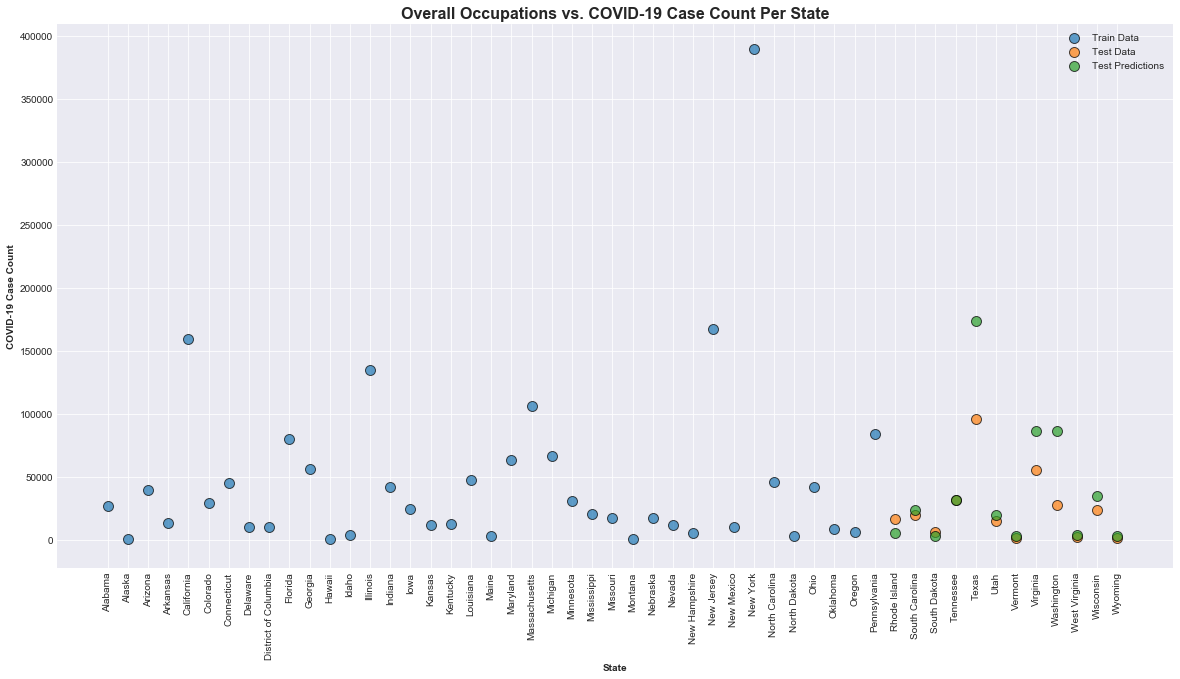

In [57]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall Occupations vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [58]:
base_accuracy = evaluate(RandomForestModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8074 degrees.
Accuracy = 92.11%.


In [59]:
new_accuracy = evaluate(RF_NewModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7692 degrees.
Accuracy = 92.72%.


In [60]:
print('Improvement of {:0.2f}%.'.format( 100 * (new_accuracy - base_accuracy) / new_accuracy))

Improvement of 0.65%.


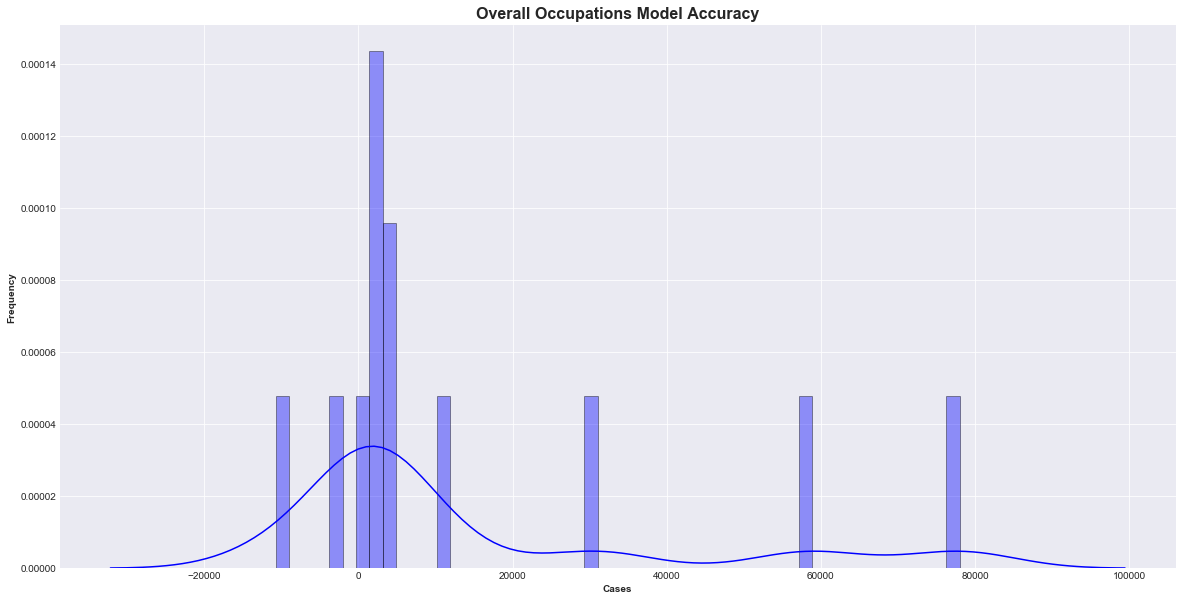

In [61]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Overall Occupations Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();